In [35]:
import os
import re 
import pandas as pd
import seaborn as sns 
import numpy as np 
import chardet

import warnings

pointMiniGames = "Sammelwahn, Schießstand, Walls, Mini Survivalgames, Mini Skywars, Lasertag, Minengefecht, Einer im Köcher, Paintball, Spleef, Buntes Chaos, Reihenfolge, Duelle" 
timeMiniGames = "Wettrennen, Jump and Run, Pferderennen, Drachenflucht, Replika, Blockhüpfer, Todeswürfel, Freier Fall, Elytrarennen, Waffenfolge, Minenfeld, Kletter-König, Ampelrennen, Hoch hinaus, Frostiger Pfad"

miniGameList = ["1-Sammelwahn",
        "2-Schießstand",
        "3-Wettrennen",
        "4-Pferderennen",
        "5-Drachenflucht",
        "6-Jump and Run",
        "7-Hoch Hinaus",
        "8-Blockhüpfer",
        "9-Todeswürfel",
        "10-Freier Fall",
        "11-Elytrarennen",
        "12-Waffenfolge",
        "13-Minenfeld",
        "14-Kletterkönig",
        "15-Ampelrennen",
        "16-Replika",
        "17-Walls",
        "18-Mini SG",
        "19-Mini SW",
        "20-Lasertag",
        "21-Minengefecht",
        "22-OITC",
        "23-Paintball",
        "24-Spleef",
        "25-Buntes Chaos",
        "26-Reihenfolge",
        "27-Duelle",
        "28-Frotiger Pfad"]

def getPlayerPaths():
    file_list = os.listdir('in-new')
    return file_list

def read_file(file, enc='auto'):

    with open('in-new/' + file, 'rb') as f:
        raw_data = f.read()
    
    # Detect the encoding
    if enc == 'auto':
        # detected = chardet.detect(raw_data)
        encoding = 'iso-8859-2'
    encoding = 'iso-8859-2'

    # debug print(f"Detected encoding for {file}: {encoding}")
    
    # Now read the file with the detected encoding
    with open('in-new/' + file, 'r', encoding=encoding) as f:
        data = f.read().replace('TooltipEvent, ', '')
    
    return data

def getRecordData(playerPath, minigame, enc='auto'):
    data = read_file(playerPath, enc=enc).split('\n')
    for line in data: 
        if minigame in line: 
            minigameData = line
            minigameData = minigameData.replace(minigame, '').strip()
            return minigameData  # return the data instead of printing it

def create_dataframe(input_string, minigame):

    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(?:(\d+)\s*min\s*)?(?:(\d+)\s*s\s*)?(\d+)\s*ms'

    # Find all matches in the input string
    try: matches = re.findall(pattern, input_string)
    except: matches = None

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    if matches: 
        for match in matches:
            map_name = match[0]
            minutes = int(match[1] or 0)
            seconds = int(match[2] or 0) + int(match[3]) / 1000
            time_seconds = minutes * 60 + seconds
            data[map_name] = time_seconds
    else: return pd.DataFrame()

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])


    return df


def createPointDataframe(input_string, minigame):
    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(\d+)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    for match in matches:
        map_name = match[0]
        time_value = int(match[1])
        data[map_name] = time_value

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])
    return df.fillna(0)


paths = getPlayerPaths()

def getRecordsDataframe(minigame='Wettrennen', save=False, log=False, html=False, encoding='auto'):
    outDf = pd.DataFrame()

    if log:
        print(f'processing {minigame}...')

    if minigame in pointMiniGames: 
        pass
    elif minigame in timeMiniGames:
        pass
    else: 
        ValueError('Not a valid minigame name')

    for i in paths:
        if minigame in timeMiniGames:
            df = create_dataframe(getRecordData(playerPath=i, minigame=minigame, enc='auto'), minigame)
        if minigame in pointMiniGames:
            try: 
                df = createPointDataframe(getRecordData(playerPath=i, minigame=minigame, enc='auto'), minigame)
                df.fillna(0, inplace=True)
            except: 
                continue

        if df is not None:  
            df.index = [i.replace('.txt', '')]
            outDf = pd.concat([outDf, df])

    outPath = 'out/' + minigame + '.json'

    '''
        Minigame Specific changes to the df
    '''
    with pd.option_context('mode.chained_assignment', None):
        if ("Replika" in minigame): 

            replikaDf = outDf 

            # fillNa columns without "ms" with values from "ms", e.g. ms Arrow -> Arrow, then drop "ms" columns

            try:
                replikaDf["Arrow"] = replikaDf["Arrow"].fillna(replikaDf["ms Arrow"])
                replikaDf["Cow"] = replikaDf["Cow"].fillna(replikaDf["ms Cow"])
                replikaDf["Deadpool"] = replikaDf["Deadpool"].fillna(replikaDf["ms Deadpool"])
                replikaDf["Doge"] = replikaDf["Doge"].fillna(replikaDf["ms Doge"])
                replikaDf["Sonic"] = replikaDf["Sonic"].fillna(replikaDf["ms Sonic"])

                replikaDf.drop(columns=["ms Arrow", "ms Cow", "ms Deadpool", "ms Doge", "ms Sonic"], inplace=True)
            except: print("Warning, >ms< columns not found in ReplikaDf")

            replikaDf.fillna(25, inplace=True) # assigning a value to a never-played-before pattern, 17 perturbs worse player order and alt account stats lol, 27 is probably too much, difficult to choose an appropriate value here
            row_sums = replikaDf.sum(axis=1)
            
            # Append the sum as a new column
            replikaDf['Sum'] = row_sums

            # Re-indexing
            replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)
        
            # Move 'Sum' column to the first position
            cols = replikaDf.columns.tolist()
            cols = ['Sum'] + [col for col in cols if col != 'Sum']
            replikaDf = replikaDf[cols]

            # replace 25 values again with None
            replikaDf = replikaDf.replace(25, np.nan)

            # replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)


            # Removing player data with too many NaNs (players that haven't played most of the patterns)
            # replikaDf = replikaDf.drop(columns=["Ritokii", "Feinberg", "Sebi1801"])

            outDf = replikaDf

        if ("Sammelwahn" in minigame):

            row_sums = outDf.sum(axis=1)

            # Append the sum as a new column
            outDf['Sum'] = row_sums

            # Re-indexing
            outDf = outDf.reindex(sorted(outDf.columns), axis=1)

            # Move 'Sum' column to the first position
            cols = outDf.columns.tolist()
            cols = ['Sum'] + [col.lstrip() for col in cols if col != 'Sum']
            outDf = outDf[cols]

            # remove "Punkte" from all columns
            outDf.columns = outDf.columns.str.replace('Punkte', '')

        if ("Lasertag" in minigame):
            # Merge the columns "tungen Port" and "Port" into one column
            
            # debug 
            # print(outDf.columns)

            outDf["Tötungen Port"] = outDf["Tötungen Port"].replace(0, np.nan)

            outDf["temp1"] = outDf["Tötungen Port"]
            try: outDf.drop(columns=["Port"], inplace=True)
            except: pass
            outDf["Port"] = outDf["temp1"]

            outDf["Tötungen Neon"] = outDf["Tötungen Neon"].replace(0, np.nan)

            outDf["temp2"] = outDf["Tötungen Neon"]
            try: outDf.drop(columns=["Neon"], inplace=True)
            except: pass
            outDf["Neon"] = outDf["temp2"]

            outDf.drop(columns=["temp1", "temp2", "Tötungen Neon", "Tötungen Port"], inplace=True)  

        if ("Einer im Köcher" in minigame):
            outDf["Tötungen Asia"] = outDf["Tötungen Asia"].replace(0, np.nan)
            outDf["Asia"] = outDf["Asia"].replace(0, np.nan)

            outDf["temp1"] = outDf["Asia"].fillna(outDf["Tötungen Asia"])
            try: outDf.drop(columns=["Asia", "Tötungen Asia"], inplace=True)
            except: pass
            outDf["Asia"] = outDf["temp1"]

            outDf["Tötungen Japan"] = outDf["Tötungen Japan"].replace(0, np.nan)
            outDf["Japan"] = outDf["Tötungen Japan"]

            outDf.drop(columns=["temp1", "Tötungen Japan"], inplace=True)
            
        if ("Paintball" in minigame):
            outDf["Tötungen Arabic"] = outDf["Tötungen Arabic"].replace(0, np.nan)

            outDf["temp1"] = outDf["Tötungen Arabic"]
            try: outDf.drop(columns=["Tötungen Arabic"], inplace=True)
            except: pass
            outDf["Arabic"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)

            # SW Columns: Swamp', 'Tötung Asia', 'Tötungen Asia', 'Tötungen Coconut', 'Wild West', 'tung Asia', 'tungen Asia'

        if ("Mini Skywars" in minigame):
            outDf["Tötungen Asia"] = outDf["Tötungen Asia"].replace(0, np.nan)
            outDf["Tötung Asia"] = outDf["Tötung Asia"].replace(0, np.nan)
            #outDf["tung Asia"] = outDf["tung Asia"].replace(0, np.nan)

            outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["Tötung Asia"])
            #outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["tung Asia"])
            outDf["temp1"] = outDf["Tötungen Asia"]
            try: outDf.drop(columns=["Tötung Asia", "Tötungen Asia"], inplace=True)
            except: pass
            outDf["Asia"] = outDf["temp1"]

            outDf["Tötungen Coconut"] = outDf["Tötungen Coconut"].replace(0, np.nan)
            #outDf["tungen Coconut"] = outDf["tungen Coconut"].replace(0, np.nan)

            #outDf["temp2"] = outDf["tungen Coconut"].fillna(outDf["Tötungen Coconut"])
            try: outDf.drop(columns=["tungen Coconut", "Tötungen Coconut"], inplace=True)
            except: pass
            #outDf["Coconut"] = outDf["temp2"]

            outDf["Rust"] = outDf["Tötungen Rust"]
            outDf.drop(columns=["Tötungen Rust"], inplace=True)

            outDf.drop(columns=["temp1"], inplace=True)

        if ("Minengefecht" in minigame):
            outDf["Tötungen Overworld"] = outDf["Tötungen Overworld"].replace(0, np.nan)
            outDf["Overworld"] = outDf["Overworld"].replace(0, np.nan)

            outDf["temp1"] = outDf["Overworld"].fillna(outDf["Tötungen Overworld"])
            outDf["temp1"] = outDf["temp1"]

            try: outDf.drop(columns=["Overworld", "Tötungen Overworld"], inplace=True)
            except: pass
            outDf["Overworld"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)
            
            outDf["Tötungen Ruin"] = outDf["Tötungen Ruin"].replace(0, np.nan)

            outDf["temp2"] = outDf["Tötungen Ruin"]
            try: outDf.drop(columns=["Tötungen Ruin"], inplace=True)
            except: pass
            outDf["Ruin"] = outDf["temp2"]

            outDf.drop(columns=["temp2"], inplace=True)

            try: outDf.drop(columns=["Tötung Overworld", "Tötung Ruin"], inplace=True)
            except: pass

        if ("Spleef" in minigame):
            outDf["Tötungen Mountains"] = outDf["Tötungen Mountains"].replace(0, np.nan)
            outDf["Mountains"] = outDf["Mountains"].replace(0, np.nan)

            outDf["temp1"] = outDf["Mountains"].fillna(outDf["Tötungen Mountains"])
            outDf["temp1"] = outDf["temp1"]

            try: outDf.drop(columns=["Mountains", "Tötungen Mountains"], inplace=True)
            except: pass
            outDf["Mountains"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)

        if ("Skywars" in minigame):
            outDf["Tötungen Coconut"] = outDf["Tötungen Coconut"].replace(0, np.nan).fillna(outDf["Tötung Coconut"])

            outDf["temp1"] = outDf["Tötungen Coconut"]
            try: outDf.drop(columns=["Tötungen Coconut"], inplace=True)
            except: pass
            outDf["Coconut"] = outDf["temp1"]

            outDf.drop(columns=["temp1", "Tötung Coconut"], inplace=True)

        if ("Walls" in minigame):
            
            outDf["Tötungen Grass"] = outDf["Tötungen Grass"].replace(0, np.nan)
            outDf["Grass"] = outDf["Grass"].replace(0, np.nan)
            outDf["Tötung Grass"] = outDf["Tötung Grass"].replace(0, np.nan)

            outDf["temp1"] = outDf["Grass"].fillna(outDf["Tötungen Grass"])
            outDf["temp1"] = outDf["temp1"].fillna(outDf["Tötung Grass"])

            try: outDf.drop(columns=["Grass", "Tötungen Grass", "Tötung Grass"], inplace=True)
            except: pass

            outDf["Grass"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)
            
            outDf["Tötungen Vulcano"] = outDf["Tötungen Vulcano"].replace(0, np.nan)

            outDf["temp2"] = outDf["Tötungen Vulcano"]
            try: outDf.drop(columns=["Tötungen Vulcano"], inplace=True)
            except: pass
            outDf["Vulcano"] = outDf["temp2"]

            outDf.drop(columns=["temp2"], inplace=True)

            try: outDf.drop(columns=["Tötung Vulcano"], inplace=True)
            except: pass

        if ("Schie" in minigame):
            outDf["Punkte City"] = outDf["Punkte City"].replace(0, np.nan)
            outDf["City"] = outDf["City"].replace(0, np.nan)

            outDf["temp1"] = outDf["City"].fillna(outDf["Punkte City"])
            try: outDf.drop(columns=["City", "Punkte City"], inplace=True)
            except: pass

            outDf["City"] = outDf["temp1"]

            outDf["Punkte Jungle"] = outDf["Punkte Jungle"].replace(0, np.nan)

            outDf["temp1"] = outDf["Punkte Jungle"]
            try: outDf.drop(columns=["Punkte Jungle"], inplace=True)
            except: pass

            outDf["Jungle"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)
            
        if ("Frostiger" in minigame): 
            # remove values bigger than 100 with nan
            outDf = outDf.where(outDf < 100, np.nan)

        if ("Duel" in minigame): 
            outDf = outDf.where(outDf > 10, 0.0)

        if ("Spleef" in minigame):

            outDf["Tötung Mountains"] = outDf["Tötung Mountains"].replace(0, np.nan)
            outDf["Mountains"] = outDf["Mountains"].replace(0, np.nan)

            outDf["temp1"] = outDf["Mountains"].fillna(outDf["Tötung Mountains"])
            try: outDf.drop(columns=["Mountains", "Tötung Mountains"], inplace=True)
            except: pass
            outDf["Mountains"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)

        if ("Einer im Köcher" in minigame):
            outDf["Tötung Asia"] = outDf["Tötung Asia"].replace(0, np.nan)
            outDf["Asia"] = outDf["Asia"].replace(0, np.nan)

            outDf["temp1"] = outDf["Asia"].fillna(outDf["Tötung Asia"])
            try: outDf.drop(columns=["Asia", "Tötung Asia"], inplace=True)
            except: pass
            outDf["Asia"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)

        if ("Buntes" in minigame):
            outDf = outDf.fillna(0)
            
            outDf['temp1'] = outDf["Runden Cyberpunk"].fillna(outDf["Cyberpunk"])
            outDf.drop(columns=["Runden Cyberpunk", "Cyberpunk"], inplace=True)

            outDf['Cyberpunk'] = outDf['temp1']

            outDf.drop(columns=["temp1"], inplace=True)

        if ("Pferd" in minigame):
            outDf["s Arena"] = outDf["s Arena"].replace(0, np.nan)
            outDf["Wario's Arena"] = outDf["s Arena"]

            outDf.drop(columns=["s Arena"], inplace=True)
            
        if ("rvival" in minigame): 
            outDf.columns = outDf.columns.str.replace('Tötungen ', '')


        # Sorting columns alphabetically for any outDf except if minigame == "Replika" (sum column)
        
        if ("Replika" not in minigame):
            if ("Sammelwahn" not in minigame):
                outDf = outDf.reindex(sorted(outDf.columns), axis=1)


    '''
        debugging options and html export for figure generation
    '''
        
    if save: 
        if "Replika" in minigame: 
            json_df = outDf.iloc[:, 1:]
            json_df.T.to_json(outPath)
        
        else: outDf.T.to_json(outPath) 


    if html: 
        log = False 
        html_table = ""
        if ("Drache" in minigame) or ("Mini" in minigame) or ("Köcher" in minigame) or ("Lasertag" in minigame) or ("Minengef" in minigame) or ("Paint" in minigame) or ("Reihenf" in minigame) or ("Sammel" in minigame) or ("Schießs" in minigame) or ("Spleef" in minigame) or ("Walls" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('<td>NaN</td>', '<td>0</td>').replace('.0</td>', '</td>').replace('Tötungen Asia', 'Asia').replace('Tötungen', '').replace('Punkte', '')
        elif ("Pferde" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9', '>09').replace('>8', '>08').replace('>7', '>07').replace('>6', '>06').replace('>5', '>05').replace('>4', '>04').replace('s Arena', "Wario's Arena").replace('>Cheep B', ">Cheep Cheep B")
        elif ("Replika" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9.', '>09.').replace('>8.', '>08.').replace('>7.', '>07.').replace('>6.', '>06.').replace('>5.', '>05.').replace('>4.', '>04.').replace('>3.', '>03.').replace('>ms ','>').replace('>30.000','>None')
        elif ("Wettrennen" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('Blossom', 'Cherry Blossom').replace('>3', '>03').replace('>4', '>04').replace('>5', '>05').replace('>6', '>06').replace('>7', '>07').replace('>8', '>08').replace('>9', '>09')
        elif ("Elytra" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('>9', '>09').replace('>8', '>08').replace('>7', '>07').replace('>6', '>06').replace('>5', '>05').replace('>4', '>04').replace('>3', '>03')
        else: 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('Blossom', 'Cherry Blossom')
        
        print(html_table)

    if log: 
        print(f'{minigame} processed and saved to {outPath}')

    if html == False: 
        return outDf
    
import json

def export_records_json(minigames):
    all_records = []
    for minigame in sorted(minigames):
        records = getRecordsDataframe(minigame=minigame, save=False, log=False, encoding='iso')
        
        # Print column names for debugging
        print(f"Columns for {minigame}: {records.columns.tolist()}")
        
        for player_name, row in records.iterrows():
            record = {
                "name": player_name,
                "minigame": minigame,
                "scores": {}
            }
            
            # Assuming all non-index columns are map names
            for map_name in records.columns:
                score = row[map_name]
                if pd.notna(score):  # Only include non-null scores
                    record["scores"][map_name] = score
            
            # Calculate and add the best score
            if record["scores"]:
                record["best_score"] = max(record["scores"].values())
            
            all_records.append(record)
    
    return json.dumps(all_records, indent=2)

def jsonExport():
    minigames = (pointMiniGames + ', ' + timeMiniGames).split(', ')
    json_data = export_records_json(minigames)

    # Save as separate file
    with open('records_data.json', 'w') as f:
        f.write(json_data)

    print("Data exported successfully to records_data.json")


def assembleHTML():

    # HTML assembly #

    frontWrapperList = []
    x = 0
    endWrapper = "</table> </div>"

    for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
        x = x + 1
        strX = str(x)
        frontWrapperList.append('<!-- Table: ' + i + ' --> <div id="table' + strX + '" style="display:none;"> <table id="dataframe' + strX + '" class="display nowrap">')

    print('<div class="table-container">')
    x = 0
    for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
        print(frontWrapperList[x])
        getRecordsDataframe(minigame=i, save=True, log=False, html=True, encoding="auto")
        print(endWrapper)
        x = x + 1
    print('</div>')

In [36]:
# assembleHTML() #for old DataTables implementation

In [37]:
# new JSON-based Tabulator Implementation

jsonExport()

Columns for Ampelrennen: ['Castle', 'Street']
Columns for Blockhüpfer: ['City']
Columns for Buntes Chaos: ['Cyberpunk', 'Structure']
Columns for Drachenflucht: ['Ancient City', 'Chaotic Cubes', 'Factory', 'Hills', 'Temple']
Columns for Duelle: ['Default']
Columns for Einer im Köcher: ['Asia', 'Fall', 'Japan']
Columns for Elytrarennen: ['Canyon', 'Death Star', 'River']
Columns for Freier Fall: ['Brutalism', 'Snowy Cave', 'Underground', 'Waterfalls']
Columns for Frostiger Pfad: ['Icy Lake']
Columns for Hoch hinaus: ['Global']
Columns for Jump and Run: ['Canyon', 'Sky City', 'Wet Cave']
Columns for Kletter-König: ['Garden', 'Inka']
Columns for Lasertag: ['Factory', 'Neon', 'Port']
Columns for Minenfeld: ['Desert', 'Ice Cave', 'Nether']
Columns for Minengefecht: ['Ancient City', 'Nether', 'Overworld', 'Ruin']
Columns for Mini Skywars: ['Asia', 'Coconut', 'Rust', 'Swamp', 'Tötung Rust', 'Wild West']
Columns for Mini Survivalgames: ['Canyon', 'Prison', 'Winter Village']
Columns for Paintball

In [38]:
import json
import pandas as pd
import os

def load_existing_uuids(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    return {}

def save_uuids(uuids, file_path):
    with open(file_path, 'w') as f:
        json.dump(uuids, f, indent=2)

def export_uuids(minigames, output_file):
    existing_uuids = load_existing_uuids(output_file)
    new_players = set()

    for minigame in sorted(minigames):
        records = getRecordsDataframe(minigame=minigame, save=False, log=False)
        
        for player_name in records.index:
            if player_name not in existing_uuids:
                new_players.add(player_name)

    if new_players:
        print("New players found without UUIDs:")
        for player in new_players:
            print(player)
        print("\nPlease enter UUIDs for these players (or press Enter to skip):")
        for player in new_players:
            uuid = input(f"{player}: ").strip()
            if uuid:
                existing_uuids[player] = uuid

    save_uuids(existing_uuids, output_file)
    print(f"UUIDs exported successfully to {output_file}")

def export_records_json(minigames, records_file):
    all_records = []
    for minigame in sorted(minigames):
        records = getRecordsDataframe(minigame=minigame, save=False, log=False)
        
        for player_name, row in records.iterrows():
            record = {
                "name": player_name,
                "minigame": minigame,
                "scores": {}
            }
            
            for map_name in records.columns:
                score = row[map_name]
                if pd.notna(score):  # Only include non-null scores
                    record["scores"][map_name] = score
            
            # Calculate and add the best score
            if record["scores"]:
                record["best_score"] = max(record["scores"].values())
            
            all_records.append(record)
    
    with open(records_file, 'w') as f:
        json.dump(all_records, f, indent=2)

    print(f"Records exported successfully to {records_file}")

# Usage
minigames = (pointMiniGames + ', ' + timeMiniGames).split(', ')
export_uuids(minigames, 'player_uuids.json')
export_records_json(minigames, 'records_data.json')

Warning, >ms< columns not found in ReplikaDf
UUIDs exported successfully to player_uuids.json
Warning, >ms< columns not found in ReplikaDf
Records exported successfully to records_data.json


In [39]:
import shutil
import datetime

# save Elytrarennen Snapshot for later analysis 

current_date = datetime.datetime.now().strftime("%Y-%m-%d")
shutil.copy("out/Elytrarennen.json", f"out/snapshots/Elytrarennen--{current_date}--.json")

'out/snapshots/Elytrarennen--2024-08-13--.json'

In [40]:
type(str(getRecordsDataframe(minigame='Drachenflucht', save=False, log=False, html=True)))

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Ancient City</th>      <th>Chaotic Cubes</th>      <th>Factory</th>      <th>Hills</th>      <th>Temple</th>    </tr>  </thead>  <tbody>    <tr>      <th>20LeRe10</th>      <td>116.878</td>      <td>67.774</td>      <td>155.244</td>      <td>157.494</td>      <td>158.576</td>    </tr>    <tr>      <th>2B9</th>      <td>0</td>      <td>0</td>      <td>131.134</td>      <td>138.742</td>      <td>0</td>    </tr>    <tr>      <th>2wc</th>      <td>125.249</td>      <td>88.586</td>      <td>131.312</td>      <td>144.937</td>      <td>150.838</td>    </tr>    <tr>      <th>agowskyy</th>      <td>0</td>      <td>0</td>      <td>150.111</td>      <td>155.663</td>      <td>155.536</td>    </tr>    <tr>      <th>Allooy</th>      <td>116.297</td>      <td>79.298</td>      <td>150.983</td>      <td>152.915</td>      <td>157.427</td>    </tr>    <tr>      <th>Anni808</th>      <td>118.877</td>      <td>0</td>      <td>155.106</td>

str

In [41]:
getRecordsDataframe(minigame="Mini Skywars", save=True, log=False, html=False).columns

Index(['Asia', 'Coconut', 'Rust', 'Swamp', 'Tötung Rust', 'Wild West'], dtype='object')

In [42]:
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): print(i)


Ampelrennen
Blockhüpfer
Buntes Chaos
Drachenflucht
Duelle
Einer im Köcher
Elytrarennen
Freier Fall
Frostiger Pfad
Hoch hinaus
Jump and Run
Kletter-König
Lasertag
Minenfeld
Minengefecht
Mini Skywars
Mini Survivalgames
Paintball
Pferderennen
Reihenfolge
Replika
Sammelwahn
Schießstand
Spleef
Todeswürfel
Waffenfolge
Walls
Wettrennen


In [43]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True).head(10)

Warning, >ms< columns not found in ReplikaDf


,Sum,Among Us,Apple,Arrow,Baby Yoda,Bee,Blinky,Blue Monster,Cake,Camera,...,Zombie,ms Arrow,ms Cow,ms Deadpool,ms Doge,muss los,of Meat,omb,ppHop 1,ppHop 2
Gobo9,1385.643,17.715,13.714,10.428,10.595,9.191,16.549,16.955,16.469,14.511,...,16.559,10.428,NaN,NaN,NaN,16.430,11.513,9.189,16.406,13.471
PedroZockt,1612.629,16.777,18.682,12.723,12.779,11.268,17.098,18.044,21.363,15.926,...,16.269,12.723,NaN,NaN,NaN,19.726,14.157,10.340,16.034,15.067
cediiiiii_10,1616.606,17.443,14.467,12.215,13.400,12.393,17.201,17.361,17.019,17.146,...,17.840,12.215,NaN,NaN,NaN,18.770,13.571,10.306,17.629,14.512
Fflopse,1623.568,20.914,18.257,11.809,14.733,11.767,20.255,17.065,25.301,16.778,...,17.594,11.809,NaN,NaN,NaN,17.994,13.366,12.681,17.949,18.293
Ex4cted,1664.143,17.440,18.277,11.729,15.045,10.743,17.919,18.328,18.828,16.283,...,17.623,11.729,NaN,NaN,NaN,18.637,12.064,12.806,15.330,16.969
KakaMC,1726.205,17.744,19.832,12.255,16.060,11.330,20.464,20.383,19.697,16.829,...,16.198,12.255,NaN,NaN,NaN,28.061,15.932,11.625,17.590,14.525
yiiq,1746.300,17.075,18.394,11.056,13.775,10.761,18.868,18.715,21.247,16.482,...,19.115,11.056,NaN,NaN,NaN,20.273,13.879,10.405,18.600,19.838
lizsyy,1776.604,21.085,18.882,13.372,16.566,11.100,18.912,22.717,21.133,17.278,...,19.248,13.372,NaN,NaN,NaN,18.955,14.026,12.599,19.297,15.156
DieserBear,1831.311,21.020,18.418,14.068,15.827,13.366,21.615,18.693,21.261,17.485,...,18.657,14.068,NaN,NaN,NaN,19.315,15.250,12.297,19.246,18.817
Grapfen,1946.038,20.709,18.794,13.095,18.238,13.645,22.447,24.105,21.974,18.774,...,19.860,13.095,NaN,NaN,NaN,19.778,15.605,15.487,20.991,18.300


In [44]:
getRecordsDataframe(minigame='Buntes Chaos')

,Cyberpunk,Structure
20LeRe10,22.0,27.0
2B9,23.0,23.0
2wc,23.0,23.0
agowskyy,23.0,24.0
Allooy,25.0,23.0
...,...,...
yzvm,23.0,22.0
zBro,23.0,23.0
ZweitesIch,16.0,12.0
_n3d,36.0,36.0


In [45]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].mean()/102 # mean time per pattern for all players

Warning, >ms< columns not found in ReplikaDf


23.99024147193124

In [46]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].head(10).mean()/102 # mean time per pattern for top 10 players -> this value is used to fill NaN for sum column

Warning, >ms< columns not found in ReplikaDf


16.597104901960783

In [47]:
getRecordData(playerPath=paths[0], minigame='Wettrennen')

'Islands :  1 min  16 s  058 ms Snow :  47 s  509 ms Cyberpunk :  1 min  29 s  541 ms Cherry Blossom Canyon :  1 min  28 s  009 ms Green Hills :  1 min  11 s  669 ms minecraft:paper'

In [48]:
# for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): getRecordsDataframe(minigame=i, save=False, log=False, html=True)

In [49]:
getRecordsDataframe(minigame="Replika", save=False, log=False, html=False).loc['Gobo9']

Warning, >ms< columns not found in ReplikaDf


Sum          1385.643
Among Us       17.715
Apple          13.714
Arrow          10.428
Baby Yoda      10.595
               ...   
muss los       16.430
of Meat        11.513
omb             9.189
ppHop 1        16.406
ppHop 2        13.471
Name: Gobo9, Length: 103, dtype: float64

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppDa

Warning, >ms< columns not found in ReplikaDf


C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_2100\884906666.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppDa

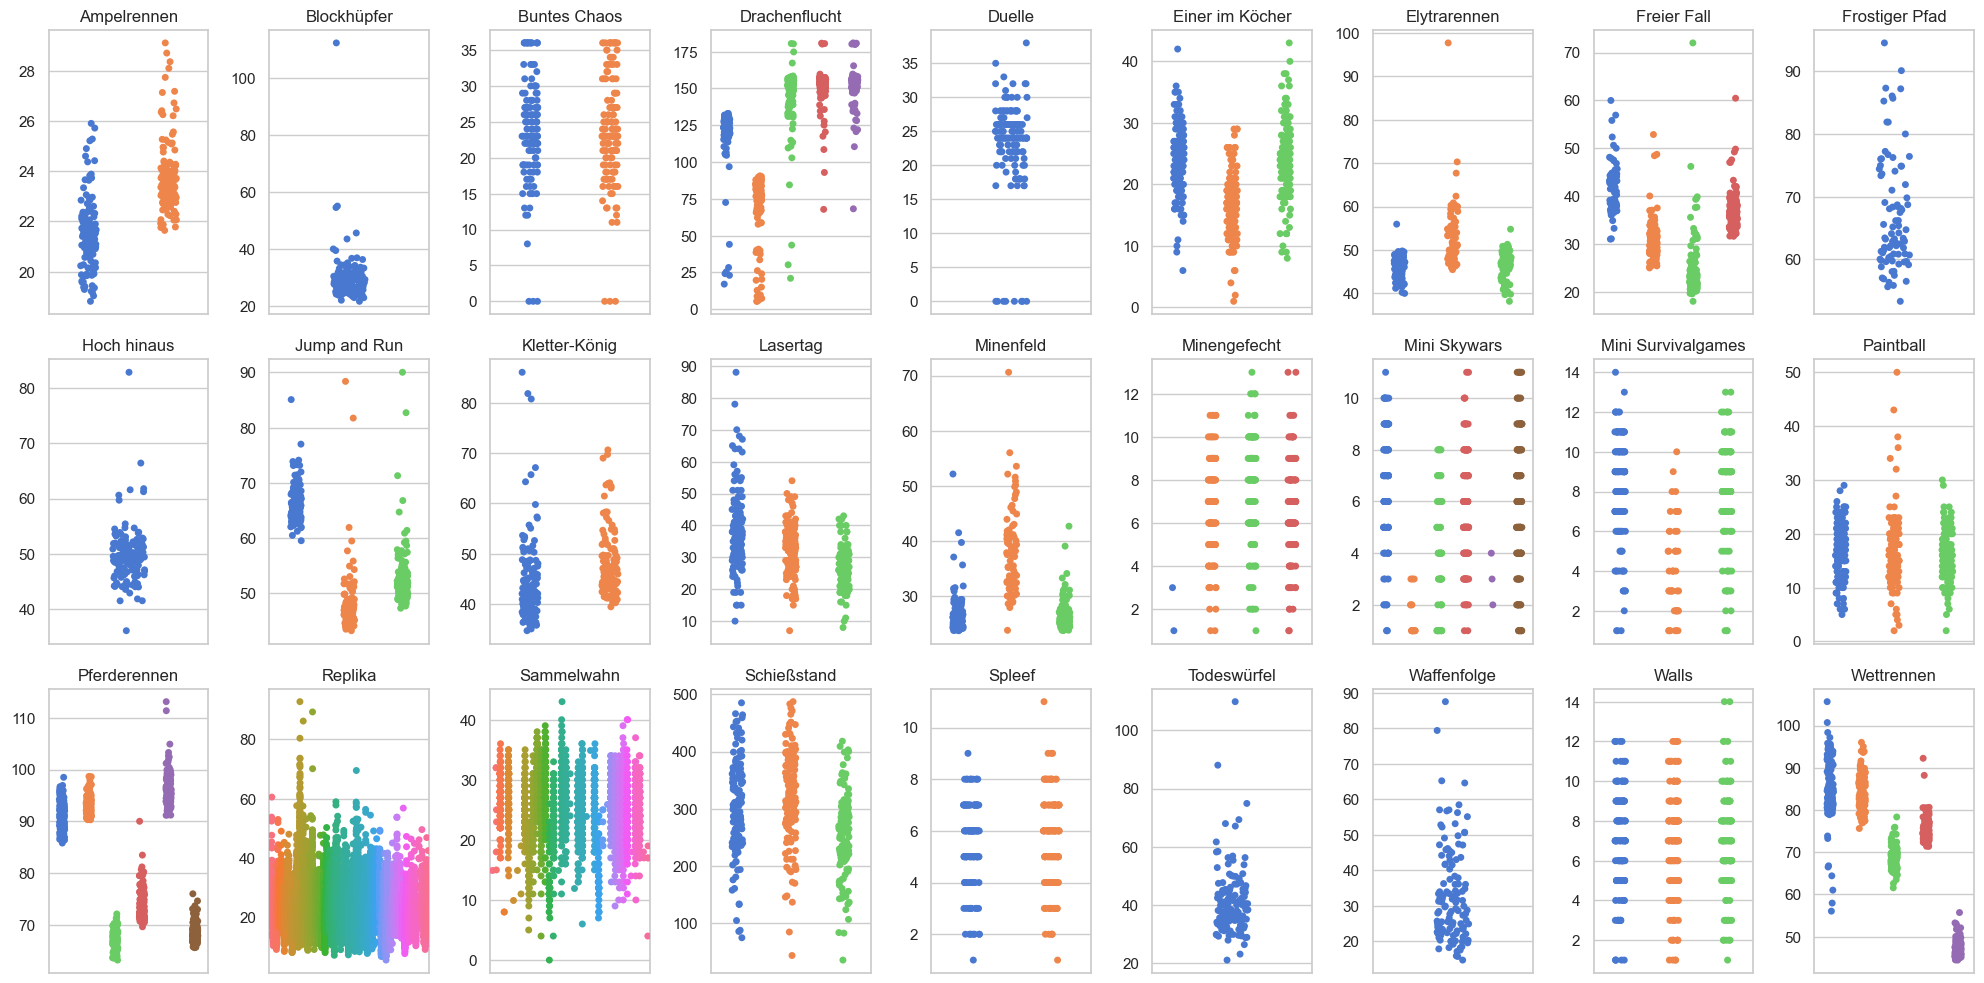

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")

# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

# remove "Reihenfolge" from the list
minigames.remove("Reihenfolge")

fig, ax = plt.subplots(ncols=9, nrows=3, figsize=[20, 10])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

# def createSmallSwarmPlots():
    # Create swarm plots for each minigame



for i, minigame in enumerate(minigames):
    data = getRecordsDataframe(minigame=minigame)
    if minigame in "Replika, Sammelwahn": 
        data = data.drop(columns=['Sum'])
    if i == 27: break 
    sns.stripplot(data=data, ax=ax[i])
    ax[i].set_title(f"{minigame}")
    ax[i].set_ylabel("")

    # Angle x-labels by 45 degrees
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

    # Hide overlapping x-labels
    plt.setp(ax[i].get_xticklabels(), visible=False)
    for label in ax[i].get_xticklabels():
        label.set_visible(False)
        if label.get_text() == '':
            continue
        if ax[i].xaxis.get_major_ticks()[-1].label1.get_window_extent().bounds[2] > ax[i].get_xlim()[1]:
            label.set_visible(False)
        elif label.get_window_extent().bounds[1] < 0:
            label.set_visible(False)

# Hide any remaining empty subplots
for i in range(len(minigames), len(ax)):
    ax[i].axis('off')

# createSmallSwarmPlots()

plt.tight_layout()
plt.show()

# plt.savefig('out/allSwarm.png')


Warning, >ms< columns not found in ReplikaDf


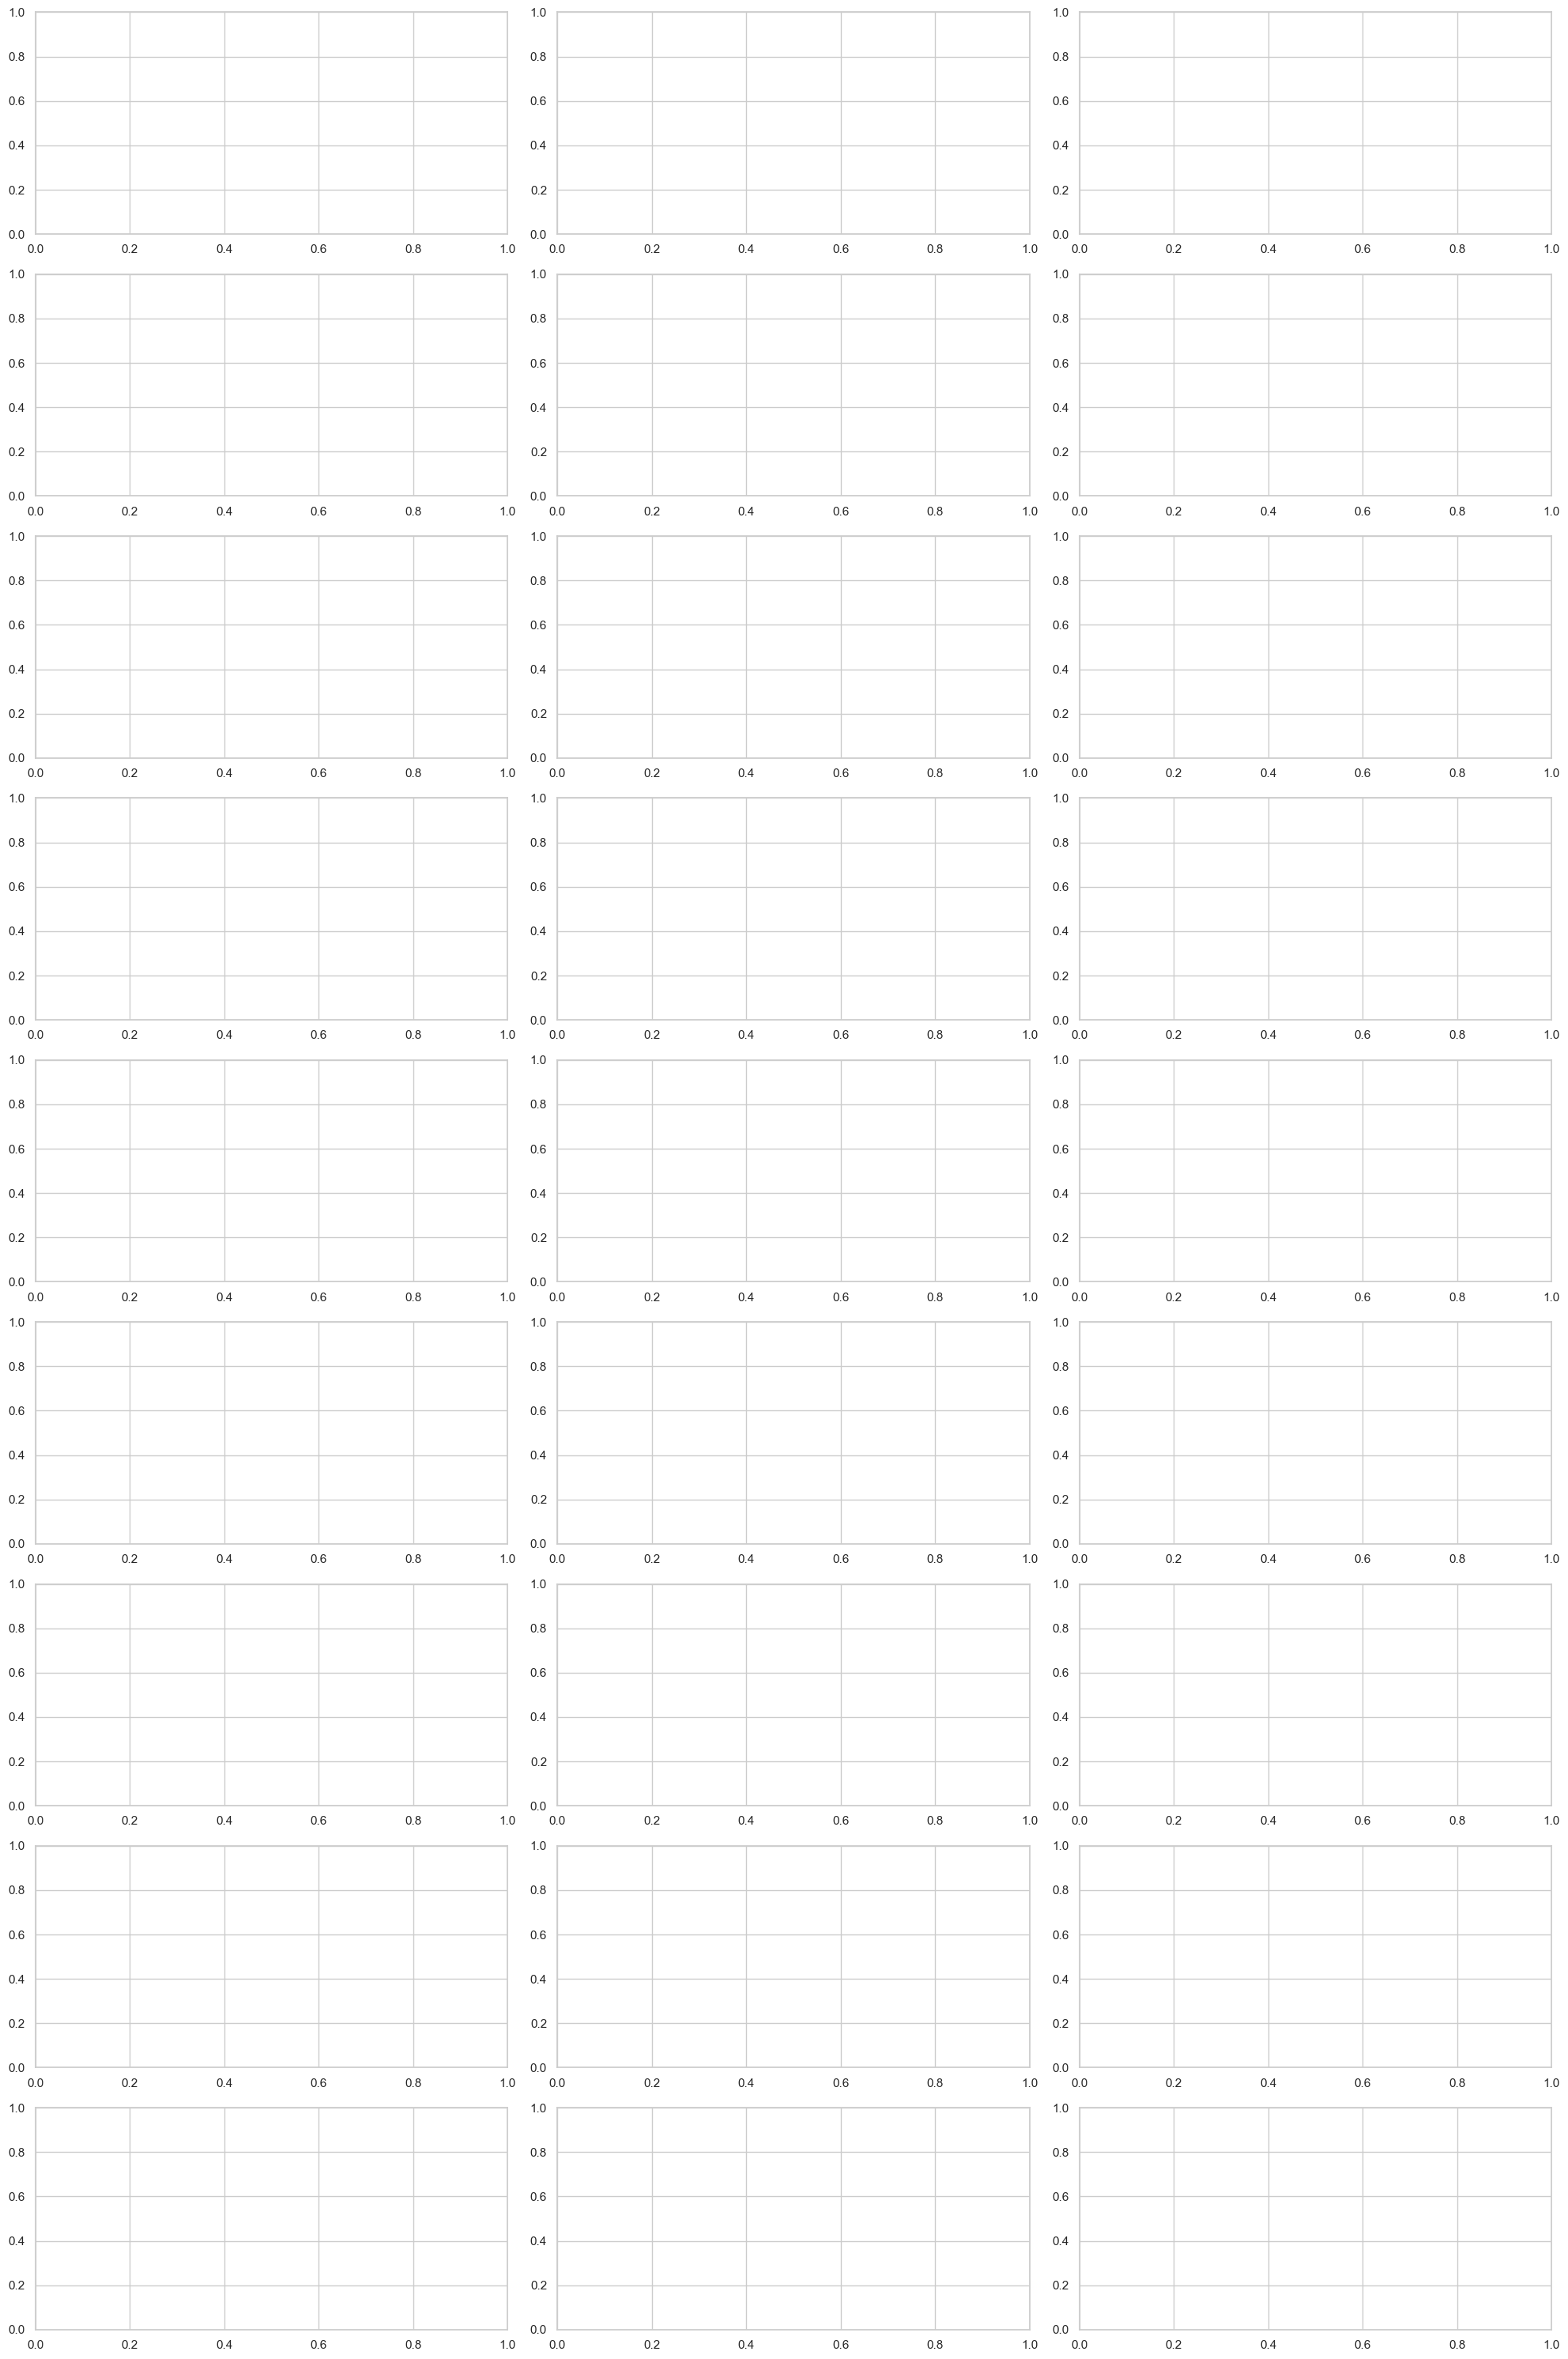

In [51]:
# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

fig, ax = plt.subplots(9, 3, figsize=[20, 30])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

data = getRecordsDataframe(minigame="Replika")
data = data.drop(columns=["Sum"])
replData = data 

# Create swarm plots for each minigame
def createLargeSwarmPlots():
    for i, minigame in enumerate(minigames):
        if "Replika" in minigame: # drop artefact columns for Replika data 
            sns.swarmplot(data=replData, ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")
            ax[i].set_xlabel("")
            ax[i].set_xticks("")
        if "Sammelwahn" in minigame: 
            sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")
            ax[i].set_xticks("")
        else:
            sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")

    # Hide any remaining empty subplots
    for i in range(len(minigames), len(ax)):
        ax[i].axis('off')

# createLargeSwarmPlots()

plt.tight_layout()
plt.show()


Warning, >ms< columns not found in ReplikaDf


C:\Users\elias\AppData\Local\Temp\ipykernel_2100\1082916974.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



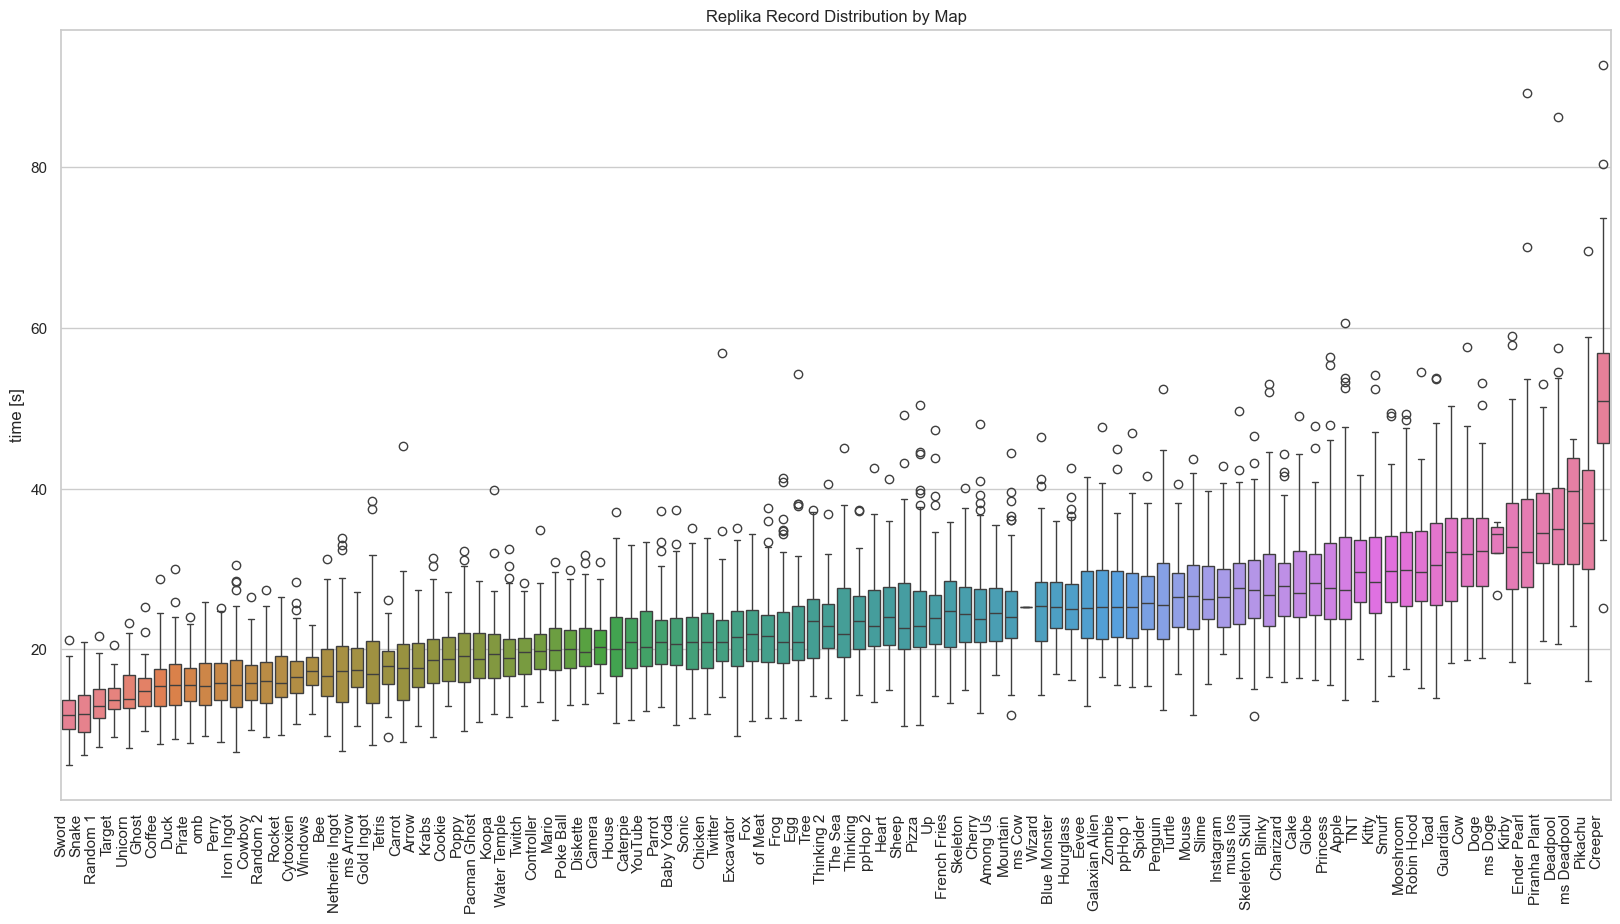

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=["Sum"])
replData = data 

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


Warning, >ms< columns not found in ReplikaDf


C:\Users\elias\AppData\Local\Temp\ipykernel_2100\1181006682.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



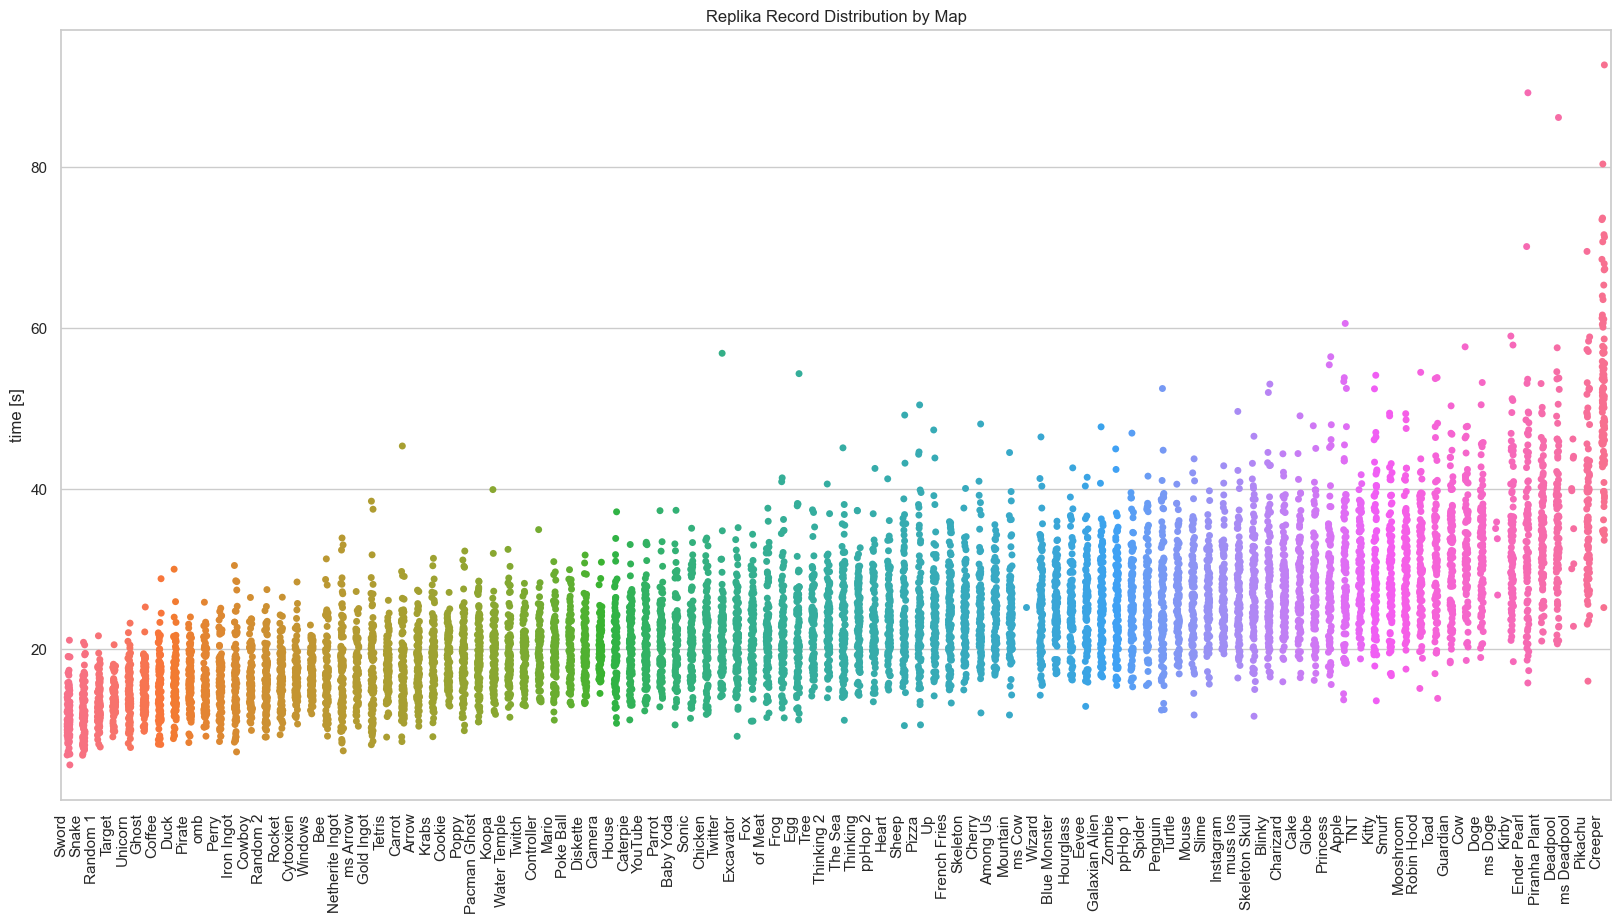

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=['Sum'])

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.stripplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_2100\1812222967.py:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



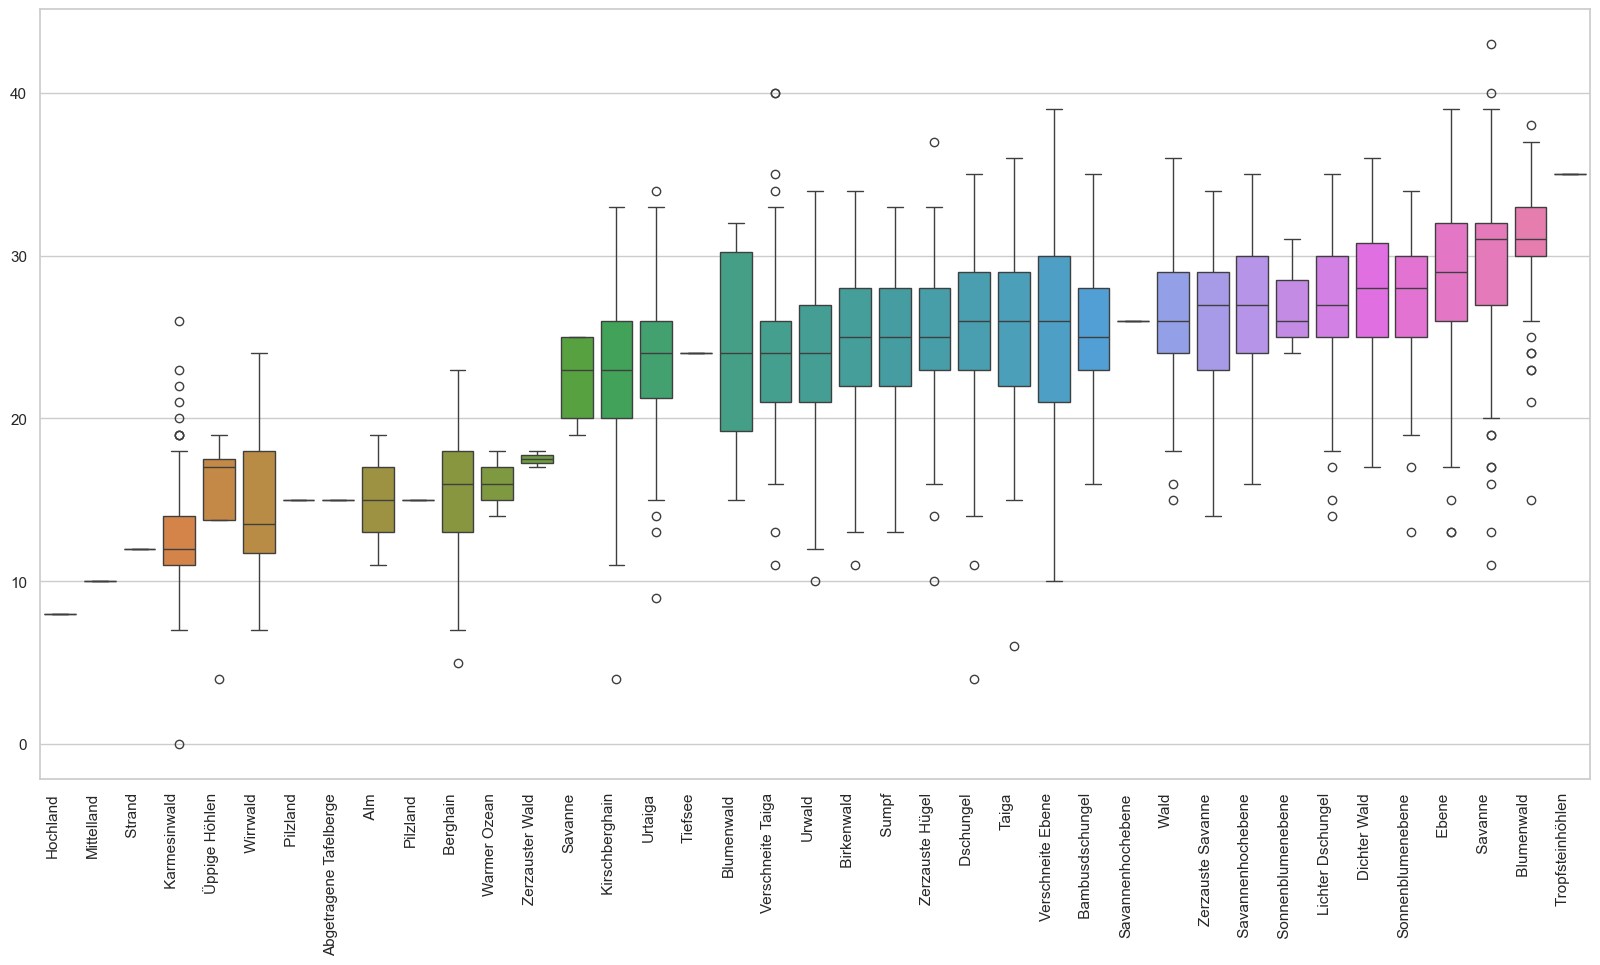

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Sammelwahn")

data.drop(columns=['Sum'], inplace=True)

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()


In [55]:
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib.colors import LinearSegmentedColormap, to_hex

df = getRecordsDataframe(minigame="Replika")

# sort df columns by mean value 
df = df.reindex(df.mean().sort_values().index, axis=1)

# drop sum column
df = df.drop(columns=["Sum"])

# replace 25 with NaN
df = df.replace(25, np.nan)

# remove "ms " from column names
df.columns = df.columns.str.replace('ms ', '')

# Exclude the first column (assuming it's the column you don't want to include)
df_to_html = df.iloc[:, 1:]

# Calculate the offset for centering the data points
num_columns = len(df_to_html.columns)
offset = 0.5

# Create a green to orange gradient
cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, (column, color) in enumerate(zip(df_to_html.columns, colors)):
    x_values = [i + offset] * len(df_to_html[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df_to_html[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Replika Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

# Show the figure
fig.show()

# Export the plot to an HTML file
pio.write_html(fig, "out/repl_swarm_plot.html")

Warning, >ms< columns not found in ReplikaDf


In [56]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Sammelwahn")

# sort df columns by mean value 
df = df.reindex(df.mean().sort_values().index, axis=1)

# drop sum column
df = df.drop(columns=["Sum"])

# remove "Punkte" from all columns
df.columns = df.columns.str.replace('Punkte', '')

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Too Many Items Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/sammel_swarm_plot.html")

In [57]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Pferderennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=8),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Horse Race Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/pferd_swarm_plot.html")

In [58]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Wettrennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=8),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Speed Race Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )


pio.show(fig)

pio.write_html(fig, "out/wettr_swarm_plot.html")

In [59]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Drachenflucht")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Dragon Escape Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/drache_swarm_plot.html")

In [60]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Minenfeld")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=8),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Mine Field Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )


pio.show(fig)

pio.write_html(fig, "out/minef_swarm_plot.html")

In [61]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Lasertag")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Lasertag Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Kills"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/laser_swarm_plot.html")

In [62]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Elytrarennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Elytrarennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/elytr_swarm_plot.html")

In [63]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Jump and Run")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=8),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="JnR Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )


pio.show(fig)

pio.write_html(fig, "out/jump_swarm_plot.html")

In [64]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Freier Fall")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
colors = [to_hex(cmap(i / (num_columns - 1))) for i in range(num_columns)]

for i, (column, color) in enumerate(zip(df.columns, colors)):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=8),  # Adjust marker color and size
                         line=dict(color=color),
                         fillcolor=color,
                         hovertext=df_to_html.index,
                         hoverinfo='name+text+y',
                         showlegend=True))

fig.update_layout(title="Dropper Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )
pio.show(fig)

pio.write_html(fig, "out/fall_swarm_plot.html")

In [65]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Schießstand")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Schießstand Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Points"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/bow_swarm_plot.html")

In [66]:
df.columns

Index(['City', 'Farm', 'Jungle'], dtype='object')

In [67]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Paintball")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Paintball Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Kills"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/paint_swarm_plot.html")

In [68]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Kletter-König")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="KOTH Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]", range=[30, 65]),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/koth_swarm_plot.html")